In [11]:
import pandas as pd

In [12]:
import pandas as pd
df = pd.read_csv('ab_test_data.csv')
df.columns, df.head()


/var/folders/3l/9mr5gprd20xggz98wcs9j_y80000gp/T/ipykernel_8958/3948288009.py:2: DtypeWarning: Columns (5,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ab_test_data.csv')


(Index(['test_name', 'vertical_id', 'rdf_offer_applied', 'customer_id',
        'rdf_offer_restaurant_max_charge', 'rdf_offer_type', 'order_state_id',
        'restaurant_id', 'order_id', 'total_net_amount', 'gmv_amount', 'amount',
        'commission', 'revenue', 'delivery_fees', 'hs_delivery_fee',
        'total_crm_hs_delivery_fee_charges',
        'total_crm_vendor_delivery_fee_charges', 'total_delivery_fee_discount',
        'total_basket_discount', 'total_net_delivery_fee_amount',
        'total_vendor_delivery_fee_charge',
        'total_vendor_delivery_fee_charge_adjusted',
        'total_trade_marketing_hs_delivery_fee_charges', 'offer_ids',
        'offer_names', 'rdf_restaurant_max_charge', 'rdf_offer_id',
        'lgs_dropoff_distance_manhattan', 'lgs_actual_delivery_time',
        'lgs_to_customer_time', 'delivery_fee_discount', 'is_subscription',
        'OD_delivery_fee', 'RD_delivery_fee'],
       dtype='object'),
                                     test_name  vertical

In [13]:
df['test_name'].unique()

array(['SA_20250414_L_G0_O_Tier_1_Removing_MOV',
       'SA_20250414_L_G0_O_Tier_1_RDF_Removing_MOV'], dtype=object)

In [16]:
df.head()

,test_name,vertical_id,rdf_offer_applied,customer_id,rdf_offer_restaurant_max_charge,rdf_offer_type,order_state_id,restaurant_id,order_id,total_net_amount,...,offer_names,rdf_restaurant_max_charge,rdf_offer_id,lgs_dropoff_distance_manhattan,lgs_actual_delivery_time,lgs_to_customer_time,delivery_fee_discount,is_subscription,OD_delivery_fee,RD_delivery_fee
0,SA_20250414_L_G0_O_Tier_1_Removing_MOV,39,1,24540005,3.0,Subscription : 100% Free Delivery,3,65969,648420639,79.0,...,"20.0 SR Referrer Referral Cashback,5 SR Delive...",3.0,1084886.0,NaN,NaN,NaN,20,True,20,0
1,SA_20250414_L_G0_O_Tier_1_RDF_Removing_MOV,39,1,24540005,3.0,Subscription : 100% Free Delivery,3,65969,648420639,79.0,...,"20.0 SR Referrer Referral Cashback,5 SR Delive...",3.0,1084886.0,NaN,NaN,NaN,20,True,20,0
2,SA_20250414_L_G0_O_Tier_1_Removing_MOV,39,0,660125,NaN,NaN,3,65969,834337907,26.9,...,"Groceries Offer 15 SAR off,Groceries offer, Fr...",3.0,1084886.0,NaN,NaN,NaN,25,False,25,0
3,SA_20250414_L_G0_O_Tier_1_RDF_Removing_MOV,39,0,660125,NaN,NaN,3,65969,834337907,26.9,...,"Groceries Offer 15 SAR off,Groceries offer, Fr...",3.0,1084886.0,NaN,NaN,NaN,25,False,25,0
4,SA_20250414_L_G0_O_Tier_1_Removing_MOV,6,1,5166272,10.0,Subscription : 100% Free Delivery,3,14514,605879553,76.0,...,5 SR Delivery fees,10.0,1070866.0,NaN,NaN,NaN,15,True,15,0


In [9]:
# 3. Quick sanity-checks
print(df['test_variant'].value_counts())     # how many orders per variant
df[['total_net_amount','gmv_amount','revenue']].describe()  # overall metric distribution


test_variant
Control       51422
Variation1    49521
Name: count, dtype: int64


,total_net_amount,gmv_amount,revenue
count,100943.000000,100943.000000,100943.000000
mean,92.912976,90.546883,19.280312
std,83.982790,83.952539,8.358968
min,0.000000,0.100000,0.000000
25%,45.925000,42.000000,14.262000
50%,69.650000,69.390000,17.880000
75%,108.160000,105.800000,22.069500
max,2249.880000,2239.880000,234.376000


rdf_offer_applied
1    160776
0    102605
Name: count, dtype: int64
Z-statistic: 15.453, p-value: 0.000


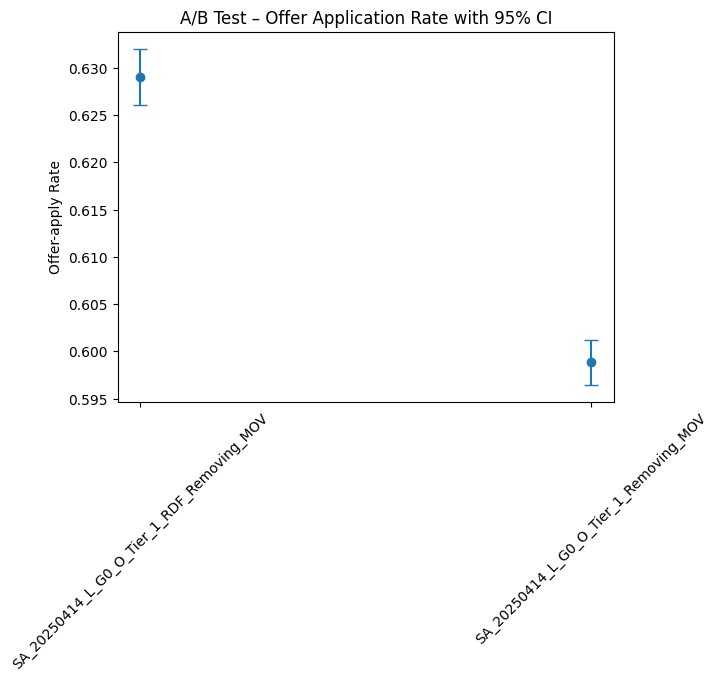

Revenue t-test: t=17.463, p=0.000


/var/folders/3l/9mr5gprd20xggz98wcs9j_y80000gp/T/ipykernel_8958/3067567485.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([grpA, grpB], labels=agg['test_name'])


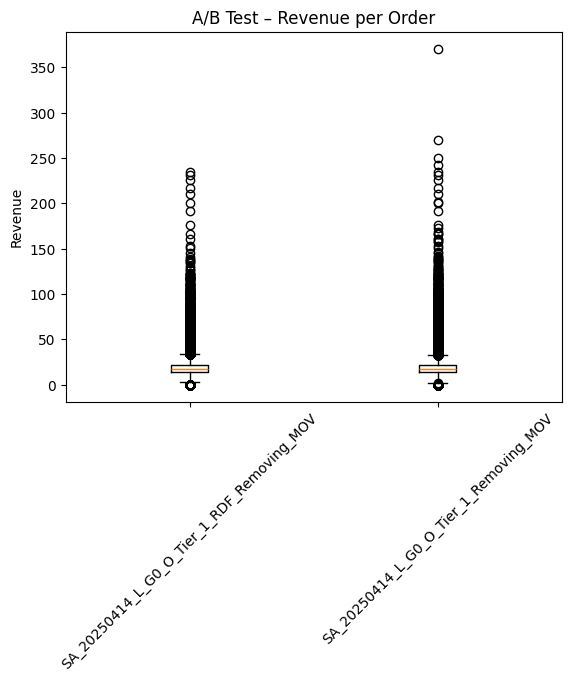

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy import stats



# 2. Pick your metric
#   • Binary: did the user apply the offer?
#   • Continuous: e.g. revenue per order
print(df['rdf_offer_applied'].value_counts())  # check it’s 0/1

# 3. Aggregate binary metric
agg = df.groupby('test_name')['rdf_offer_applied'] \
        .agg(n='count', conversions='sum') \
        .reset_index()
agg['rate'] = agg['conversions'] / agg['n']
# 95% CI
ci = agg.apply(lambda r: proportion_confint(r['conversions'], r['n'], method='normal'), axis=1)
agg[['ci_lower','ci_upper']] = list(ci)

# 4. Two-proportion z-test
z_stat, p_val = proportions_ztest(agg['conversions'], agg['n'])
print(f"Z-statistic: {z_stat:.3f}, p-value: {p_val:.3f}")

# 5. Plot binary rates
plt.errorbar(
    agg['test_name'], agg['rate'],
    yerr=[agg['rate']-agg['ci_lower'], agg['ci_upper']-agg['rate']],
    fmt='o', capsize=5
)
plt.xticks(rotation=45)
plt.ylabel('Offer-apply Rate')
plt.title('A/B Test – Offer Application Rate with 95% CI')
plt.show()

# 6. (Optional) Compare average revenue per order
grpA = df.loc[df['test_name']==agg.loc[0,'test_name'],'revenue']
grpB = df.loc[df['test_name']==agg.loc[1,'test_name'],'revenue']
t_stat, p_rev = stats.ttest_ind(grpA, grpB, equal_var=False)
print(f"Revenue t-test: t={t_stat:.3f}, p={p_rev:.3f}")

# 7. Plot revenue distribution
plt.boxplot([grpA, grpB], labels=agg['test_name'])
plt.xticks(rotation=45)
plt.ylabel('Revenue')
plt.title('A/B Test – Revenue per Order')
plt.show()


In [17]:
import pandas as pd



# 2. Identify the two variants
variants = df['test_name'].unique()

# 3. Define only the metrics we *can* compute from your columns:
metrics_funcs = {
    'orders':                          lambda d:                 len(d),
    'users':                           lambda d:        d['customer_id'].nunique(),
    'orders_per_user':                 lambda d: len(d) / d['customer_id'].nunique(),
    'avg_gmv':                         lambda d:     d['gmv_amount'].mean(),
    'avg_commission':                  lambda d:      d['commission'].mean(),
    'avg_delivery_costs':              lambda d:     d['delivery_fees'].mean(),
    'avg_to_customer_time':            lambda d: d['lgs_to_customer_time'].mean(),
    'avg_travel_time':                 lambda d: d['lgs_actual_delivery_time'].mean(),
    'avg_manhattan_distance':          lambda d: d['lgs_dropoff_distance_manhattan'].mean(),
    'avg_revenue':                     lambda d:         d['revenue'].mean(),
    'avg_profit':                      lambda d: (d['revenue'] - d['commission'] - d['delivery_fees']).mean(),
    'cvr':                             lambda d: d['rdf_offer_applied'].mean(),
    'total_conversions':               lambda d:      d['rdf_offer_applied'].sum(),
    'gmv_per_user':                    lambda d: d['gmv_amount'].sum() / d['customer_id'].nunique(),
    'commission_per_user':             lambda d:  d['commission'].sum() / d['customer_id'].nunique(),
    'delivery_costs_per_user':         lambda d: d['delivery_fees'].sum() / d['customer_id'].nunique(),
    'revenue_per_user':                lambda d:       d['revenue'].sum() / d['customer_id'].nunique(),
    'travel_time_per_user':            lambda d: d['lgs_actual_delivery_time'].sum() / d['customer_id'].nunique(),
    'profit_per_user':                 lambda d: (d['revenue'] - d['commission'] - d['delivery_fees']).sum() / d['customer_id'].nunique(),
    'total_revenue':                   lambda d:         d['revenue'].sum(),
    'total_cost':                      lambda d: (d['commission'] + d['delivery_fees']).sum(),
    'total_profit':                    lambda d: (d['revenue'] - d['commission'] - d['delivery_fees']).sum(),
    'total_gmv':                       lambda d:     d['gmv_amount'].sum(),
}

# 4. Compute each metric for Control vs Variation
results = {}
for v in variants:
    sub = df[df['test_name'] == v]
    results[v] = {m: func(sub) for m, func in metrics_funcs.items()}

# 5. Build a DataFrame & round for clarity
summary = pd.DataFrame(results).T.round(2)
summary.index.name = 'variant'

# 6. Show the result
print(summary)

# 7. Report the KPIs we *cannot* calculate from your columns:
cannot_compute = [
    'sessions', 'Adjusted orders (by sessions)', 'avg_paid_df', 'avg_dps_df',
    'DF (HS Source)', 'avg_mov', 'avg_fv', 'avg_fleet_delay',
    'CVR3', 'mCVR2', 'mCVR3', 'mCVR4',
    'DF_per_user', 'GFV Per User',
    'Monthly Adjusted Order impact', 'Monthly Revenue (LC/month)',
    'Monthly Impact (LC/month)', 'GMV impact', 'GMV impact (%)',
    'Monthly GMV impact (LC/month)', 'CPI'
]
print("\nMetrics not computable with available data:")
print(", ".join(cannot_compute))


                                              orders     users  \
variant                                                          
SA_20250414_L_G0_O_Tier_1_Removing_MOV      162438.0  115692.0   
SA_20250414_L_G0_O_Tier_1_RDF_Removing_MOV  100943.0   78692.0   

                                            orders_per_user  avg_gmv  \
variant                                                                
SA_20250414_L_G0_O_Tier_1_Removing_MOV                 1.40    91.20   
SA_20250414_L_G0_O_Tier_1_RDF_Removing_MOV             1.28    90.55   

                                            avg_commission  \
variant                                                      
SA_20250414_L_G0_O_Tier_1_Removing_MOV                5.56   
SA_20250414_L_G0_O_Tier_1_RDF_Removing_MOV            5.51   

                                            avg_delivery_costs  \
variant                                                          
SA_20250414_L_G0_O_Tier_1_Removing_MOV                   13.28   

In [18]:
summary

,orders,users,orders_per_user,avg_gmv,avg_commission,avg_delivery_costs,avg_to_customer_time,avg_travel_time,avg_manhattan_distance,avg_revenue,...,gmv_per_user,commission_per_user,delivery_costs_per_user,revenue_per_user,travel_time_per_user,profit_per_user,total_revenue,total_cost,total_profit,total_gmv
variant,,,,,,,,,,,,,,,,,,,,,
SA_20250414_L_G0_O_Tier_1_Removing_MOV,162438.0,115692.0,1.40,91.20,5.56,13.28,11.99,38.63,4704.58,18.69,...,128.05,7.81,18.65,26.25,53.50,-0.21,3036588.79,3060793.79,-24205.0,14814507.61
SA_20250414_L_G0_O_Tier_1_RDF_Removing_MOV,100943.0,78692.0,1.28,90.55,5.51,13.93,11.92,39.22,4690.67,19.28,...,116.15,7.07,17.87,24.73,49.61,-0.21,1946212.58,1963112.58,-16900.0,9140074.06


In [19]:
print("\nMetrics not computable with available data:")
print(", ".join(cannot_compute))


Metrics not computable with available data:
sessions, Adjusted orders (by sessions), avg_paid_df, avg_dps_df, DF (HS Source), avg_mov, avg_fv, avg_fleet_delay, CVR3, mCVR2, mCVR3, mCVR4, DF_per_user, GFV Per User, Monthly Adjusted Order impact, Monthly Revenue (LC/month), Monthly Impact (LC/month), GMV impact, GMV impact (%), Monthly GMV impact (LC/month), CPI
